In [1]:
import csv
import os
from imageio import imread
import numpy as np

In [2]:
data_path = '../drivingData'
csv_fname = 'driving_log.csv'
data_folders = os.listdir(data_path) 
print(data_folders)

# read annotation for data for images from csv file


images = []
measurements = []
for folder in data_folders:
    lines = []
    print(folder)
    part_dpath = os.path.join(data_path, folder)
    with open(os.path.join(part_dpath, csv_fname)) as csvf:
        reader = csv.reader(csvf)
        for line in reader:
            lines.append(line)

    print(f"current folder is {folder} and there are {len(lines)} lines")
    # extract image path and read images

    for line in lines:
        for i in range(3):
            source_path = line[i]
            file_path = os.path.join('IMG', source_path.split('/')[-1])
            readable_path = os.path.join(part_dpath, file_path)
            image = imread(readable_path)
            images.append(image)
            # center image
            if i == 0:
                measurement = float(line[3])
                measurements.append(measurement)
            # left image
            elif i == 1:
                measurement = float(line[3]) + 10.0
                measurements.append(measurement)
            # right image
            elif i == 2:
#                 measurement = float(line[3]) - 10.0
#                 measurements.append(measurement)
                
print(len(images))
print(len(measurements))

X_train = np.array(images)
y_train = np.array(measurements)

['center', 'track2', 'first']
center
current folder is center and there are 4789 lines
track2
current folder is track2 and there are 5246 lines
first
current folder is first and there are 5690 lines
47175
47175


MemoryError: Unable to allocate array with shape (47175, 160, 320, 3) and data type uint8

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Flatten, Dense, Lambda, Cropping2D

In [ ]:
# base line dense model
model = Sequential()
model.add(Flatten(input_shape=(160, 320, 3)))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, validation_split=0.2, shuffle=True)

model.save('model.h5')

In [ ]:
# modified LeNet from traffic sign classification project
model = Sequential()
input_shape = (160, 320, 3)
model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160,320,3)))
model.add(Lambda(lambda x: tf.cast(x, tf.float32) / 255.0 - 0.5, input_shape=input_shape))
model.add(layers.Conv2D(3, (1, 1), 1,
                        padding="valid"))
# first convolution layer
model.add(layers.Conv2D(12, (5, 5), 1,
                        padding="valid"))  # filter num, kernel size, stride, padding
model.add(layers.BatchNormalization(axis=-1))
model.add(layers.Activation("relu"))
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding="valid"))
# second convolution layer, kernel_regularizer=regularizers.l2(0.1)
model.add(layers.Conv2D(32, (5, 5), 1,
                        padding="valid",
                        input_shape=(14, 14, 12)))
model.add(layers.BatchNormalization(axis=-1))
model.add(layers.Activation("relu"))
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding="valid"))
model.add(layers.Flatten())
# first fully connected layer
model.add(layers.Dense(120))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.Dropout(0.5))
# second fully connected layer
model.add(layers.Dense(84))
model.add(layers.BatchNormalization())
# model.add(layers.Activation("relu"))
model.add(layers.Dropout(0.5))
# output layer
model.add(layers.Dense(1))
# model.add(layers.Activation("softmax"))

model.compile(loss='mse', optimizer='adam')

In [5]:
model.fit(X_train, y_train, validation_split=0.2, shuffle=True, nb_epoch=30)

model.save('model1_extend.h5')

Train on 4552 samples, validate on 1138 samples
Epoch 1/30
4552/4552 [==============================] - 25s 5ms/sample - loss: 0.4183 - val_loss: 0.0177
Epoch 2/30
4552/4552 [==============================] - 17s 4ms/sample - loss: 0.1866 - val_loss: 0.0182
Epoch 3/30
4552/4552 [==============================] - 17s 4ms/sample - loss: 0.0782 - val_loss: 0.0170
Epoch 4/30
4552/4552 [==============================] - 17s 4ms/sample - loss: 0.0386 - val_loss: 0.0163
Epoch 5/30
4552/4552 [==============================] - 17s 4ms/sample - loss: 0.0210 - val_loss: 0.0165
Epoch 6/30
4552/4552 [==============================] - 18s 4ms/sample - loss: 0.0152 - val_loss: 0.0163
Epoch 7/30
4552/4552 [==============================] - 18s 4ms/sample - loss: 0.0128 - val_loss: 0.0159
Epoch 8/30
4552/4552 [==============================] - 18s 4ms/sample - loss: 0.0120 - val_loss: 0.0151
Epoch 9/30
4552/4552 [==============================] - 18s 4ms/sample - loss: 0.0113 - val_loss: 0.0152
Epoch 1

In [4]:
# Nvidia net
model = Sequential()
input_shape = (160, 320, 3)
model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=input_shape))
model.add(Lambda(lambda x: tf.cast(x, tf.float32) / 255.0))
model.add(layers.Conv2D(3, (1, 1), 1,
                        padding="valid"))
# first convolution layer
model.add(layers.Conv2D(24, (5, 5), 1,
                        padding="valid"))  # filter num, kernel size, stride, padding
model.add(layers.BatchNormalization(axis=-1))
model.add(layers.Activation("relu"))
# model.add(layers.MaxPooling2D(pool_size=(2, 2), padding="valid"))
# second convolution layer, kernel_regularizer=regularizers.l2(0.1)
model.add(layers.Conv2D(36, (5, 5), 1,
                        padding="valid"))
model.add(layers.BatchNormalization(axis=-1))
model.add(layers.Activation("relu"))
# third conv layer
model.add(layers.Conv2D(48, (3, 3), 1,
                        padding="valid"))
model.add(layers.BatchNormalization(axis=-1))
model.add(layers.Activation("relu"))
# forth conv layer
model.add(layers.Conv2D(64, (3, 3), 1,
                        padding="valid"))
model.add(layers.BatchNormalization(axis=-1))
model.add(layers.Activation("relu"))
# model.add(layers.MaxPooling2D(pool_size=(2, 2), padding="valid"))
model.add(layers.Flatten())
# first fully connected layer
model.add(layers.Dense(120))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.Dropout(0.5))
# second fully connected layer
model.add(layers.Dense(84))
model.add(layers.BatchNormalization())
# model.add(layers.Activation("relu"))
model.add(layers.Dropout(0.5))
# output layer
model.add(layers.Dense(1))
# model.add(layers.Activation("softmax"))

In [10]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

NUM_EPOCHS = 29
INIT_LR = 2*1e-3
BS = 250
model_name = "lenet_net"         
opt = Adam(lr=INIT_LR, decay=INIT_LR / (NUM_EPOCHS * 0.5))
model.compile(loss="mse", optimizer=opt, metrics=["mse"])

checkpointer = ModelCheckpoint(filepath=f"{model_name}_best_weightss.h5", 
                               monitor = 'val_mse',
                               verbose=1, 
                               save_best_only=True)

# H = model.fit_generator(aug.flow(X_train, y_train, batch_size=BS),
#                         validation_data=(X_valid, y_valid),
#                         steps_per_epoch=X_train.shape[0] // BS,
#                         epochs=NUM_EPOCHS,
#                         callbacks=[checkpointer],
#                         class_weight=classWeight,
#                         verbose=1)
H = model.fit(X_train, y_train, validation_split=0.2,
          shuffle=True, epochs=NUM_EPOCHS, batch_size=BS,
          callbacks=[checkpointer], verbose=1)

model.save(f'{model_name}.h5')

Train on 12580 samples, validate on 3145 samples
Epoch 1/29
12500/12580 [============================>.] - ETA: 0s - loss: 0.0400 - mse: 0.0400
Epoch 00001: val_mse improved from inf to 0.05198, saving model to lenet_net_best_weightss.h5
12580/12580 [==============================] - 40s 3ms/sample - loss: 0.0400 - mse: 0.0400 - val_loss: 0.0520 - val_mse: 0.0520
Epoch 2/29
12500/12580 [============================>.] - ETA: 0s - loss: 0.0343 - mse: 0.0343
Epoch 00002: val_mse improved from 0.05198 to 0.02023, saving model to lenet_net_best_weightss.h5
12580/12580 [==============================] - 35s 3ms/sample - loss: 0.0343 - mse: 0.0343 - val_loss: 0.0202 - val_mse: 0.0202
Epoch 3/29
12500/12580 [============================>.] - ETA: 0s - loss: 0.0309 - mse: 0.0309
Epoch 00003: val_mse did not improve from 0.02023
12580/12580 [==============================] - 35s 3ms/sample - loss: 0.0309 - mse: 0.0309 - val_loss: 0.0906 - val_mse: 0.0906
Epoch 4/29
12500/12580 [================

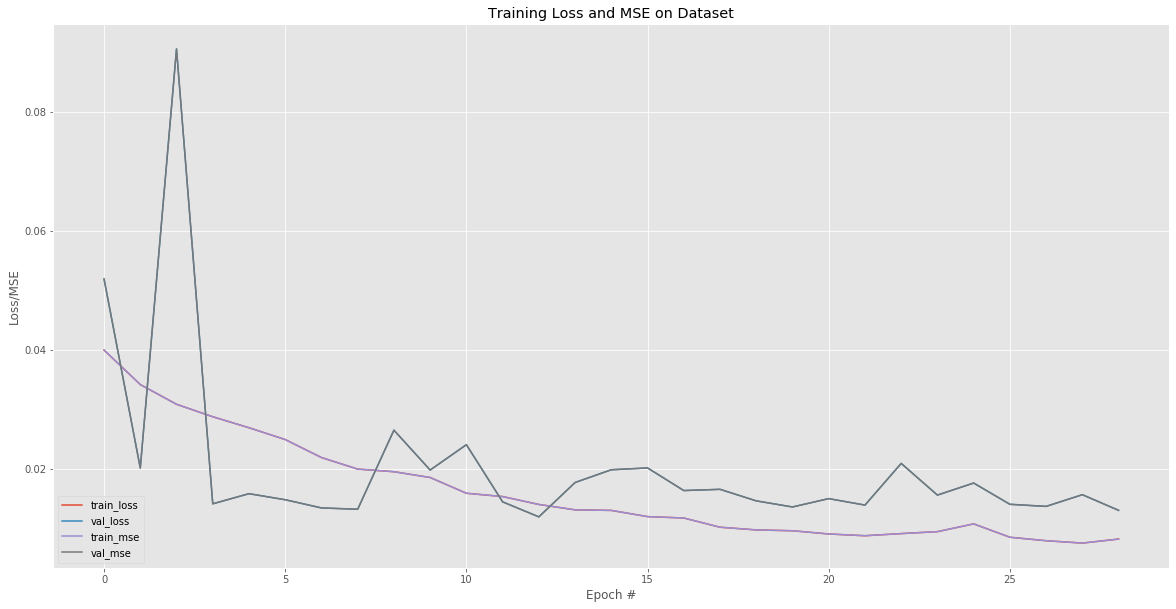

In [13]:
# plot the training loss and accuracy
import matplotlib.pyplot as plt
N = np.arange(0, NUM_EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize=(20,10))
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["mse"], label="train_mse")
plt.plot(N, H.history["val_mse"], label="val_mse")
plt.title("Training Loss and MSE on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/MSE")
plt.legend(loc="lower left")
plt.savefig(f"{model_name}.png")

In [4]:
# load model from file if we had it
model = tf.keras.models.load_model('model1.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 160, 320, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 160, 320, 3)       12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 156, 316, 12)      912       
_________________________________________________________________
batch_normalization (BatchNo (None, 156, 316, 12)      48        
_________________________________________________________________
activation (Activation)      (None, 156, 316, 12)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 78, 158, 12)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 74, 154, 32)       9

In [ ]:
test = X_train[:3] / 255
print(test[1])

In [ ]:
predictions = model.predict(test)
print(f"prediction shape is {predictions.shape}")
print(f"predictions for test is {predictions}")

In [ ]:
type
